In [ ]:
import matplotlib.pyplot as plt
import torch

from diffdrr.drr import DRR
from diffdrr.data import load_example_ct
from diffdrr.visualization import plot_drr

## DRR Generation

`DiffDRR` is implemented as a custom PyTorch module.

All raytracing operations have been formulated in a vectorized function, enabling use of PyTorch's GPU support and autograd.
This also means that DRR generation is available as a layer in deep learning frameworks.

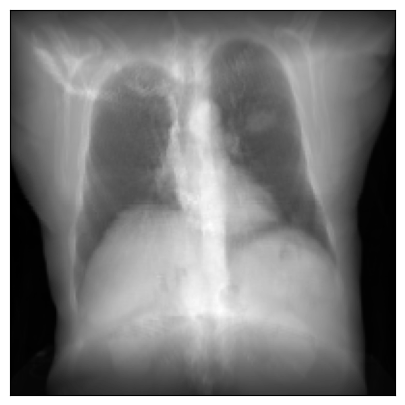

In [ ]:
#|cuda
# Read in the volume
volume, spacing = load_example_ct()
bx, by, bz = torch.tensor(volume.shape) * torch.tensor(spacing) / 2

# Rotations and translations determine the viewing angle
# They must have the same batch_size as was passed to the DRR constructor
# Rotations are (yaw pitch roll)
# Translations are (bx by bz)
rotations = torch.tensor([[torch.pi, 0.0, torch.pi / 2]])
translations = torch.tensor([[bx, by, bz]])

# Initialize the DRR module for generating synthetic X-rays
drr = DRR(
    volume,        # The CT volume as a numpy array
    spacing,       # Voxel dimensions of the CT
    sdr=300.0,     # Source-to-detector radius (half of the source-to-detector distance)
    height=200,    # Height of the DRR (if width is not seperately provided, the generated image is square)
    delx=4.0,      # Pixel spacing (in mm)
).to("cuda" if torch.cuda.is_available() else "cpu")

# Make the DRR
drr.move_carm(rotations, translations)
img = drr().detach()
ax = plot_drr(img, ticks=False)
plt.show()

We demonstrate the speed of `DiffDRR` by timing repeated DRR synthesis. Timing results are on a single NVIDIA RTX 2080 Ti GPU.

In [ ]:
#|cuda
%timeit drr().detach()

34.9 ms ± 44.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Sparse rendering

You can also render random sparse subsets of the pixels in a DRR. This is useful for speeding up registration tasks.

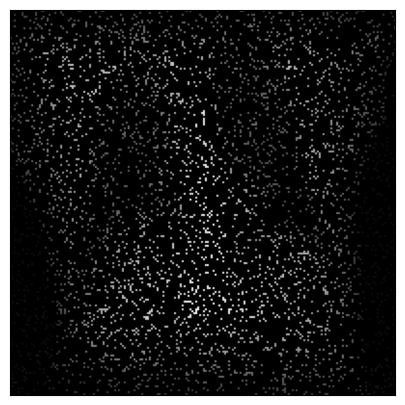

In [ ]:
#|cuda
# Make the DRR with 10% of the pixels
drr = DRR(
    volume,
    spacing,
    sdr=300.0,
    height=200,
    delx=4.0,
    p_subsample=0.1,  # Set the proportion of pixels that should be rendered
    reshape=True,     # Map rendered pixels back to their location in true space, 
                      # Useful for plotting, but can be disabled if using MSE as a loss function
).to("cuda" if torch.cuda.is_available() else "cpu")

# Make the DRR
drr.move_carm(rotations, translations)
img = drr().detach()
ax = plot_drr(img, ticks=False)
plt.show()

In [ ]:
%timeit drr().detach()

7.74 ms ± 214 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Batched DRR synthesis

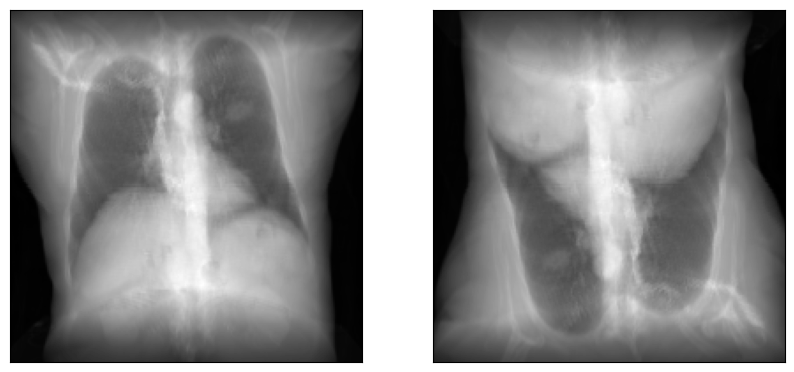

In [ ]:
# Initialize the DRR module for generating synthetic X-rays
drr = DRR(
    volume,        # The CT volume as a numpy array
    spacing,       # Voxel dimensions of the CT
    sdr=300.0,     # Source-to-detector radius (half of the source-to-detector distance)
    height=200,    # Height of the DRR (if width is not seperately provided, the generated image is square)
    delx=4.0,      # Pixel spacing (in mm)
    batch_size=2,  # How many batches of parameters will be passed = number of DRRs generated each forward pass
).to("cuda" if torch.cuda.is_available() else "cpu")

rotations = torch.tensor([[torch.pi, 0.0, torch.pi / 2], [-torch.pi, 0.0, -torch.pi / 2]])
translations = torch.tensor([[bx, by, bz], [bx, by, bz]])
drr.move_carm(rotations, translations)
img = drr().detach()
plot_drr(img, ticks=False)
plt.show()